# Anomaly Detection with Generative Adveserial Networks

This notebook shows a simple example with anomaly detection with GANs. 

It uses a simple model where Generator $G(z)$ tries to fool Discirminitor with samples whose seed is based on a random value $z$. 

Discriminator is fed with either fake samples $G(z)$ and real data $X$ and its goal is to maximize its ability to distinguish between real and fake samples

Minimax Loss https://developers.google.com/machine-learning/gan/loss

The GAN implementation is inspired by https://github.com/lyeoni/pytorch-mnist-GAN/blob/master/pytorch-mnist-GAN.ipynb



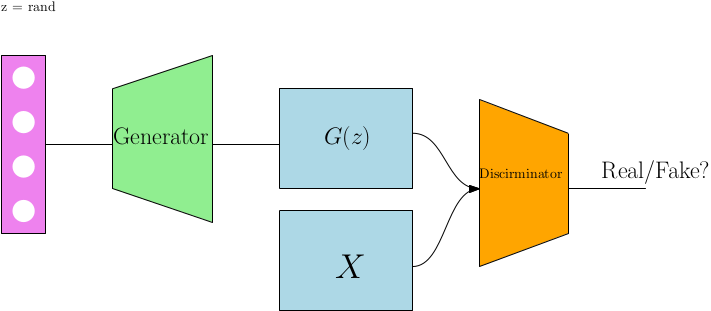

In [ ]:
!pip3 install torch torchvision numpy matplotlib tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt 
from tqdm.autonotebook import tqdm


bs = 100
n_epoch = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

toimg = lambda x : x.reshape(28,28).detach().cpu().numpy()
# Pretrained data -> training GAN without a GPU (even with gpu) takes some time
# in my case it was rougly 30 minutes, so this is a pretrained model. If you want
# to train your own model, just change train to False in the cell with training.
# !wget https: //www.dropbox.com/s/iqi5lpeb5dd1amp/gan_trained_model_200epoch.torch
!wget https://github.com/sulcantonin/ICFA-Beam-2022/blob/main/gan_trained_model_200epoch.torch

--2022-11-01 01:42:03--  https://github.com/sulcantonin/ICFA-Beam-2022/blob/main/gan_trained_model_200epoch.torch
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘gan_trained_model_200epoch.torch’

gan_trained_model_2     [ <=>                ] 135.64K  --.-KB/s    in 0.009s  

2022-11-01 01:42:04 (15.2 MB/s) - ‘gan_trained_model_200epoch.torch’ saved [138893]



## Loading Datasets
This time we are downloading a standard MNIST which we use to train a GAN plus KMNIST with kanji letters for testing. 

In [3]:
# MNIST Dataset & EMNIST dataset
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5),(0.5,))])


train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.KMNIST(root='./kmnist_data/', train=False, transform=transform, download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting ./kmnist_data/KMNIST/raw/train-images-idx3-ubyte.gz to ./kmnist_data/KMNIST/raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting ./kmnist_data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./kmnist_data/KMNIST/raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting ./kmnist_data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./kmnist_data/KMNIST/raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting ./kmnist_data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./kmnist_data/KMNIST/raw



## Generator and Discriminator Classes
Just a standard definition of a generator and discriminator

In [ ]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [ ]:
def D_train(x):
    '''
    A method for one training epoch of a discrminiator
    '''
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on fake
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

def G_train(x):
    '''
    One training epoch for generator
    '''
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

## Training loop

In [ ]:
train = False
if train:
    for epoch in range(1, n_epoch+1):           
        D_losses, G_losses = [], []
        for batch_idx, (x, _) in enumerate(train_loader):
            D_losses.append(D_train(x))
            G_losses.append(G_train(x))

        print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
                (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
        
    torch.save({'G' : G.state_dict(), 'D' : D.state_dict()}, 'trained_model.torch')
else:
    weights = torch.load('./gan_trained_model_200epoch.torch')
    G.load_state_dict(weights['G'])
    D.load_state_dict(weights['D'])
    G = G.to(device)
    D = D.to(device)

## AnoGAN
This is the main function which optimizes the $z_\gamma$ like it is shown in the ANOGAN paper

In [ ]:
def anogan_z(x,G,D,l = 0.2, z0 = None, lr = 0.005, epochs = 1000):
    ''' This function uses trained generator @G and discriminator @D
    to score reconstruct the a corrupted input. If neither (and at the same time) 
     - generator @G is not able to reconstruct a sample while optimizing latent var. $z$
     - discriminator @D is rankining the optimized $z$ as as "fake" (in GAN sense)
    '''

    if z0 is None:
        z0 = torch.randn((1,z_dim)).to(device)
    
    z = torch.autograd.Variable(z0,requires_grad = True).to(device)
    optimizer = optim.Adam([z], lr = lr)
    loss, residual_loss, discrimination_loss = [], [], []
    sigma = torch.tensor([[1.0]]).to(device)
    for epoch in range(epochs):
        g = G(z)

        residual_loss_ = F.mse_loss(x,g)
        discrimination_loss_ = F.binary_cross_entropy(D(g),sigma)

        loss_ = (1-l) * residual_loss_ + l * discrimination_loss_
        optimizer.zero_grad()
        loss_.backward()
        optimizer.step()
        loss.append(loss_.item())
        residual_loss.append(residual_loss_.item())
        discrimination_loss.append(discrimination_loss_.item())

    return z, g, loss, residual_loss, discrimination_loss

In [ ]:
batch_train = next(iter(train_loader))[0]
batch_test = next(iter(test_loader))[0]

  0%|          | 0/100 [00:00<?, ?it/s]

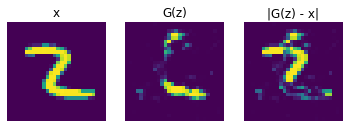

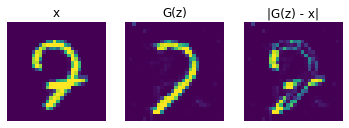

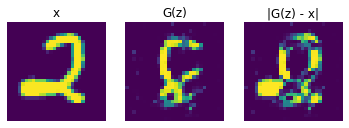

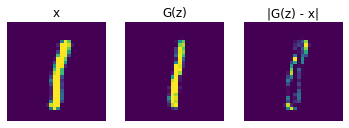

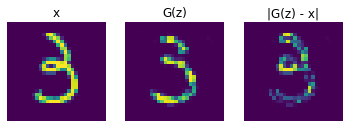

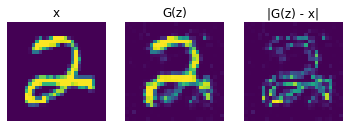

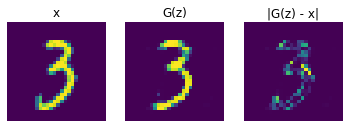

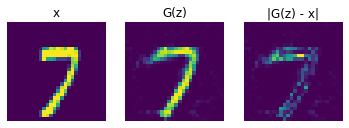

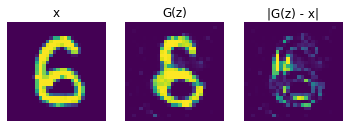

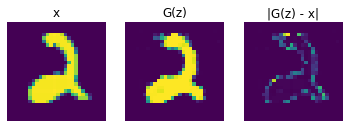

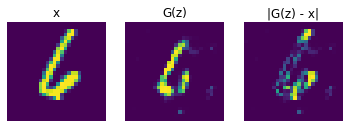

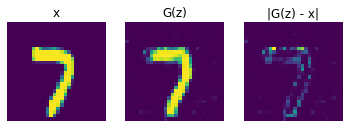

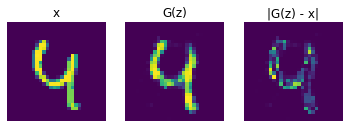

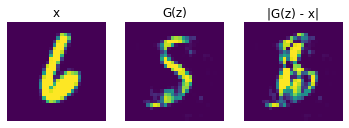

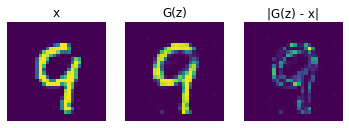

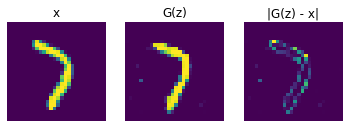

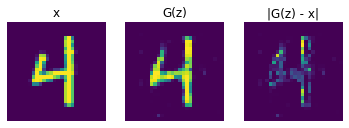

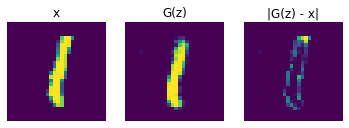

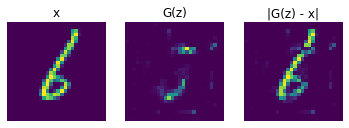

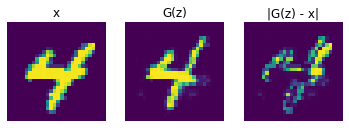

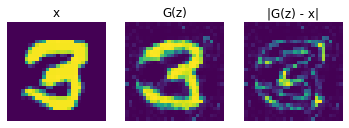

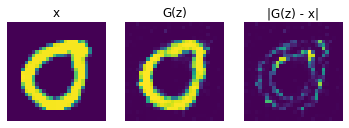

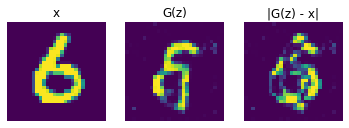

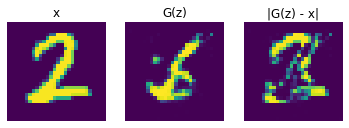

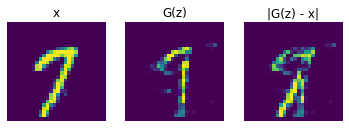

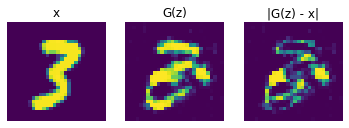

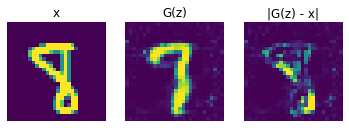

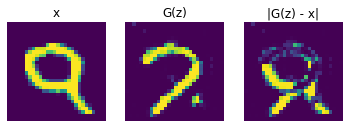

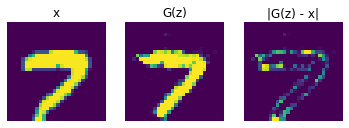

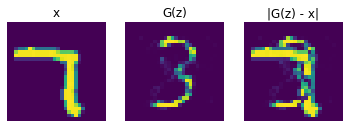

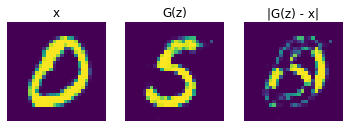

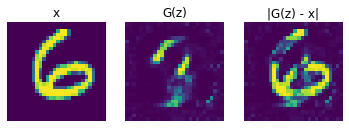

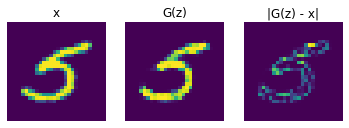

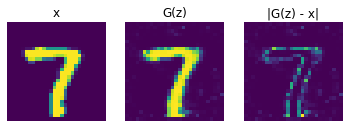

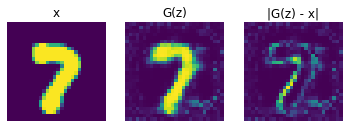

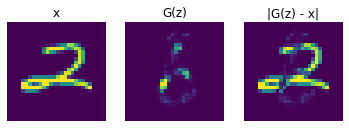

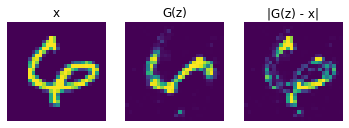

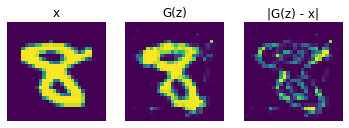

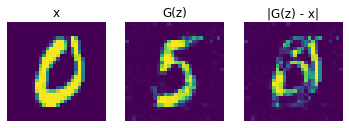

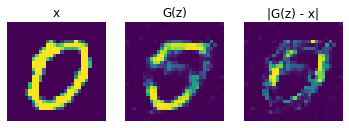

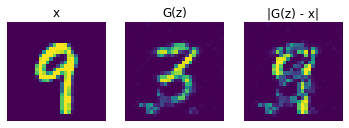

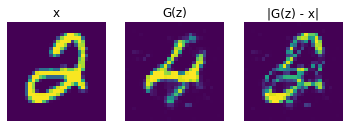

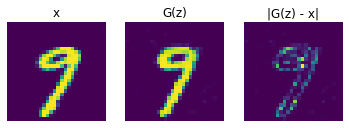

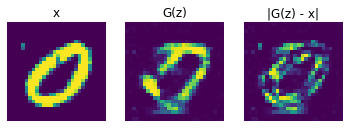

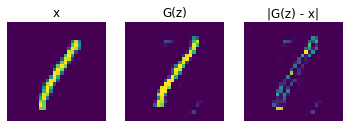

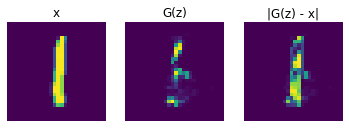

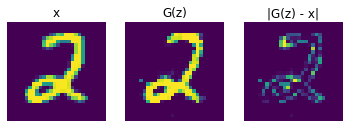

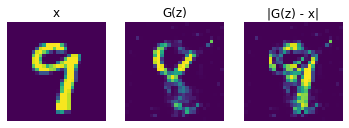

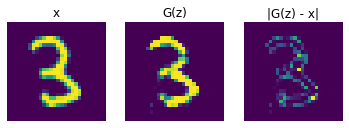

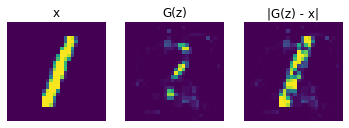

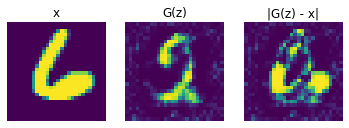

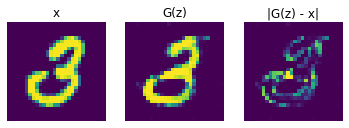

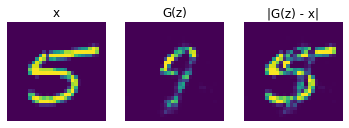

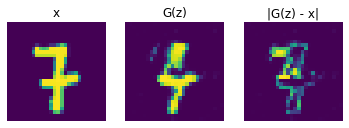

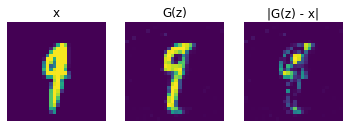

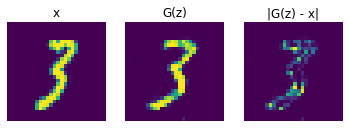

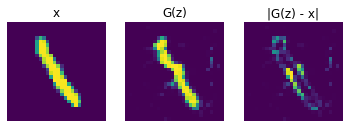

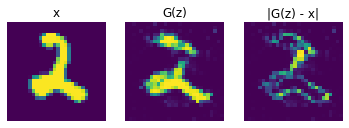

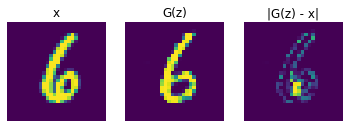

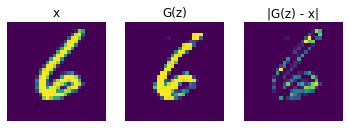

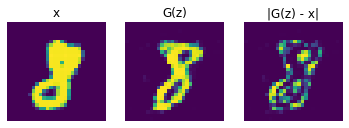

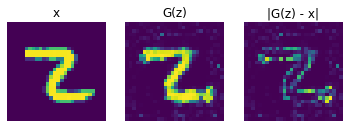

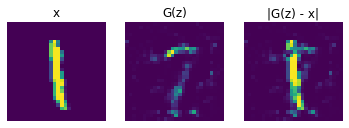

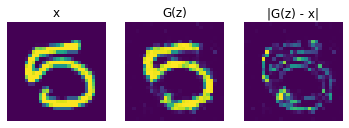

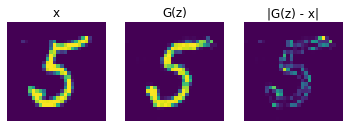

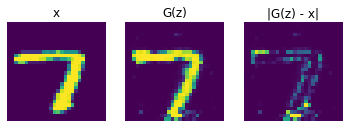

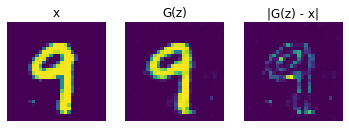

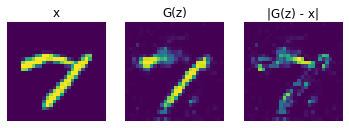

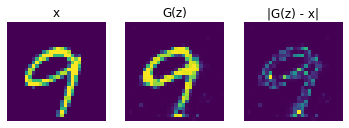

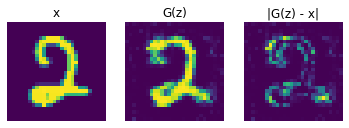

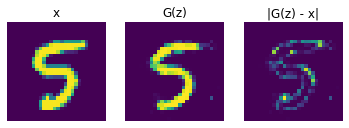

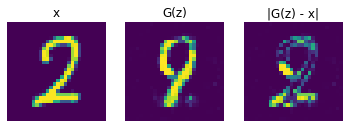

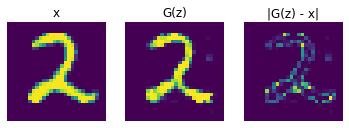

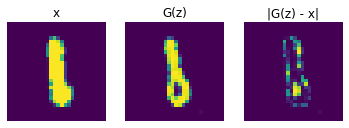

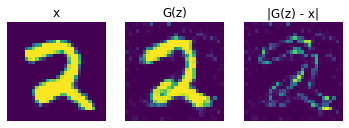

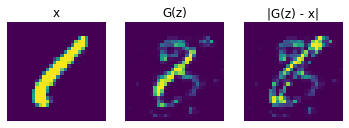

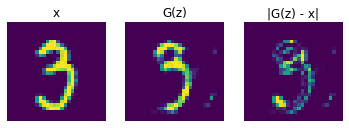

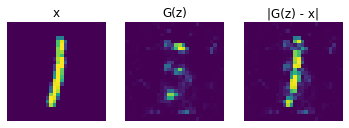

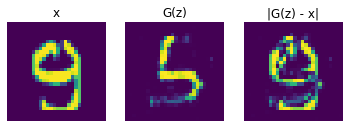

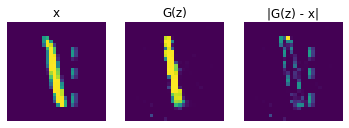

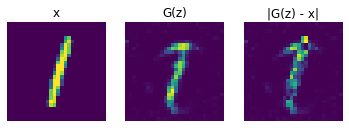

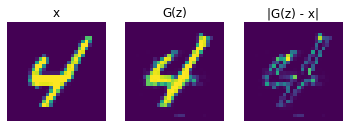

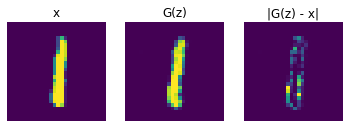

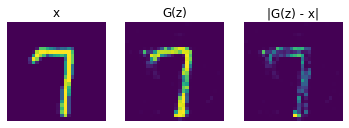

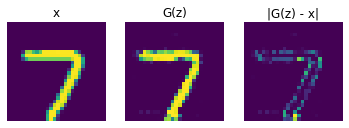

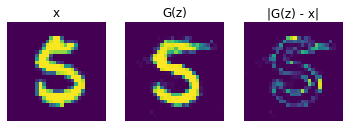

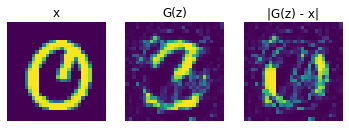

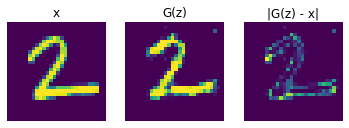

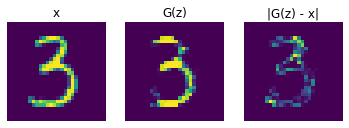

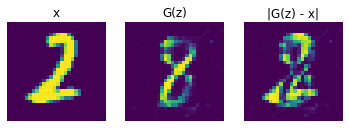

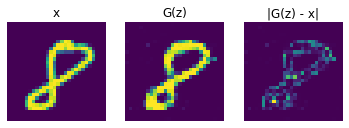

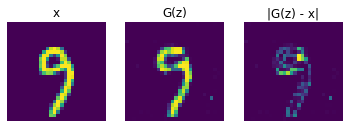

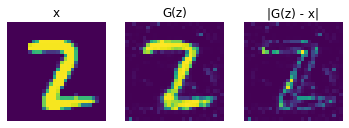

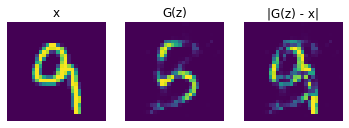

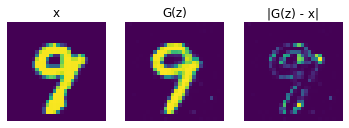

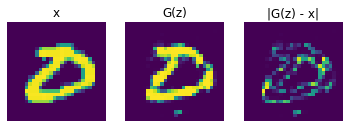

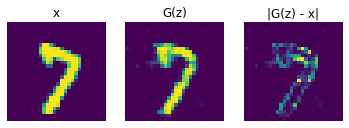

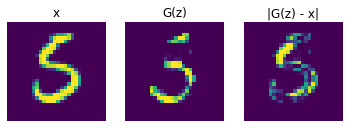

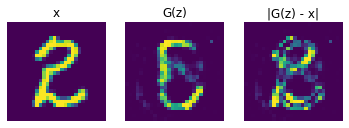

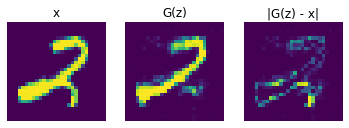

  0%|          | 0/100 [00:00<?, ?it/s]

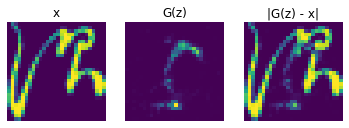

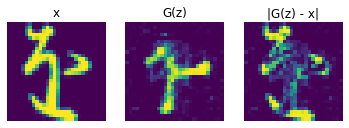

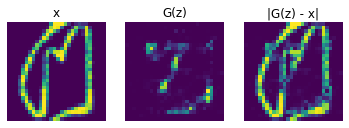

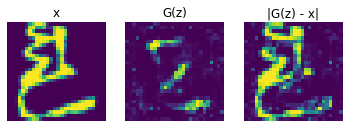

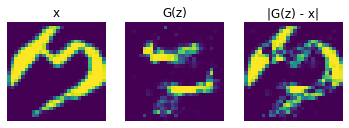

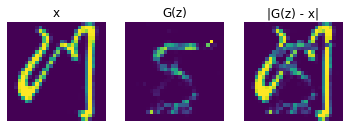

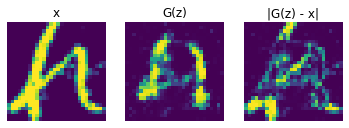

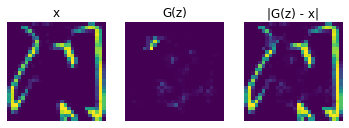

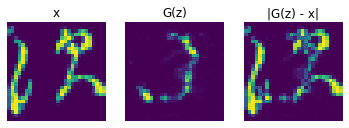

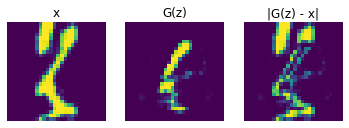

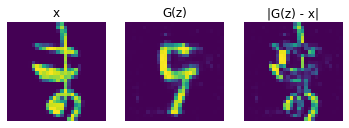

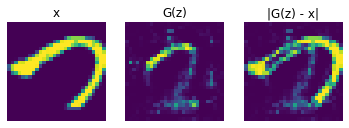

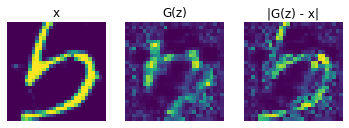

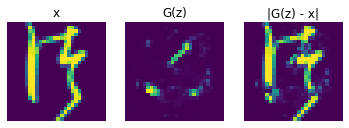

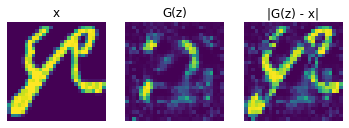

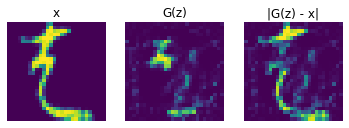

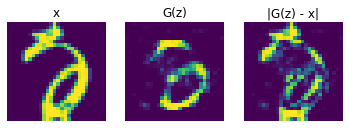

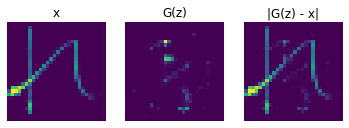

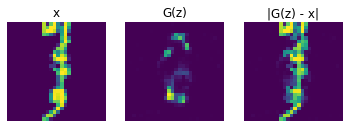

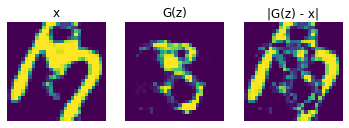

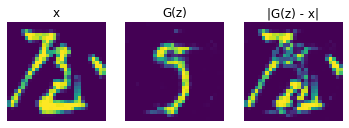

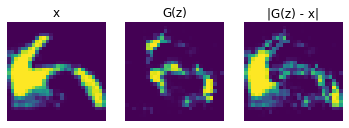

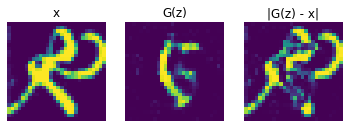

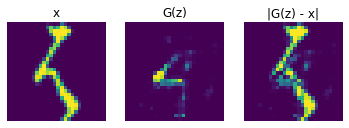

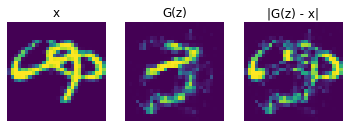

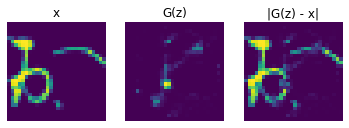

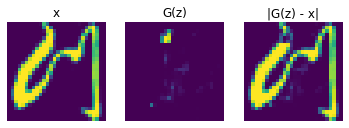

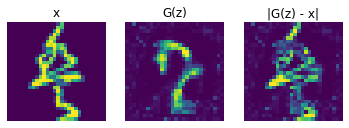

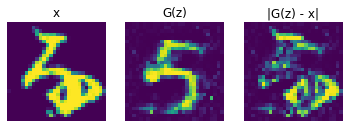

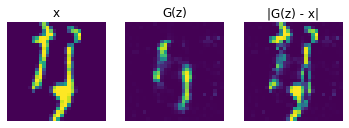

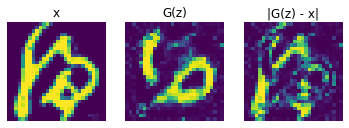

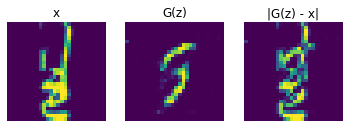

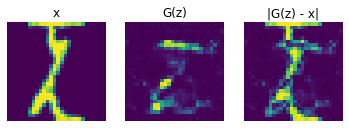

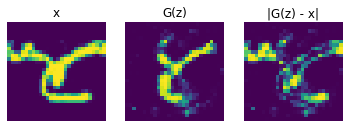

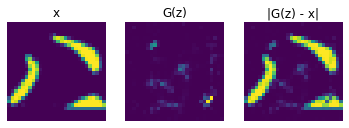

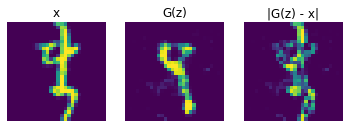

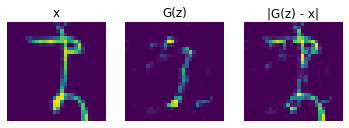

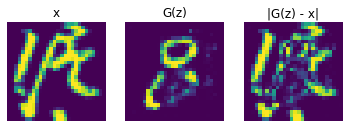

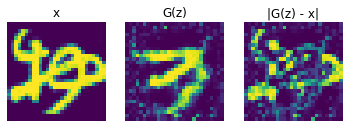

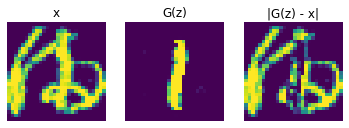

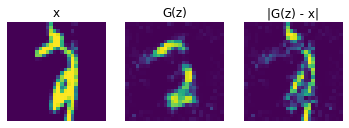

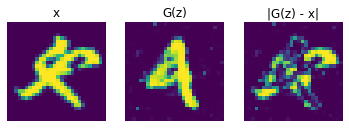

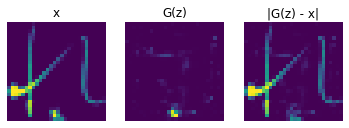

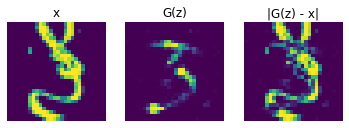

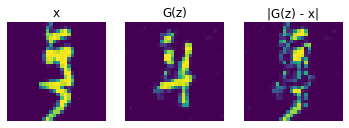

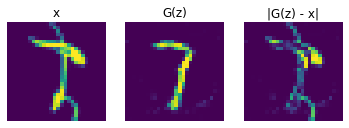

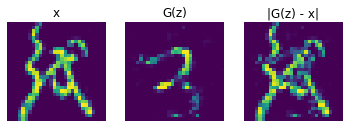

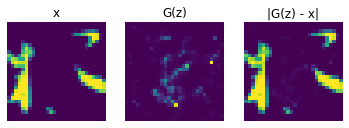

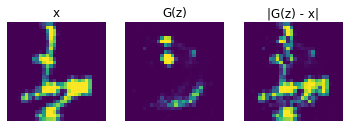

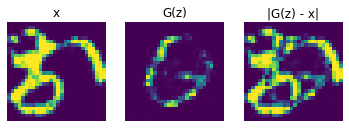

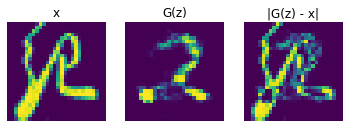

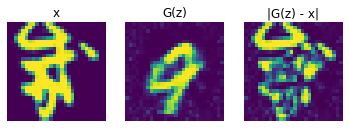

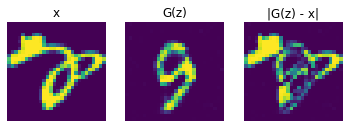

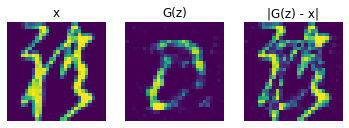

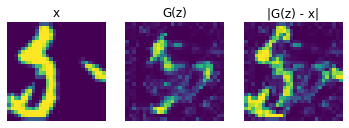

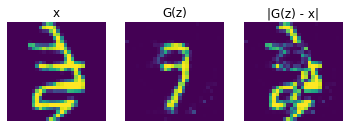

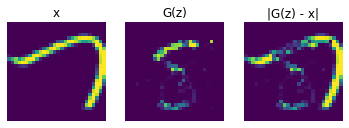

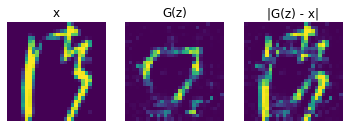

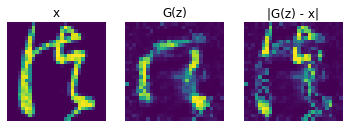

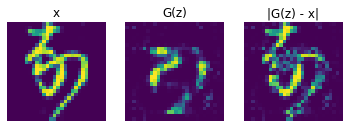

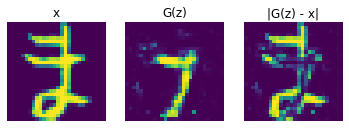

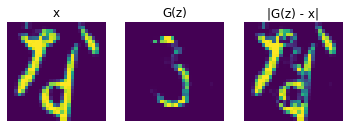

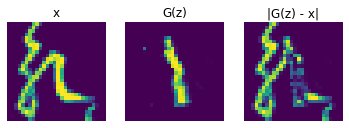

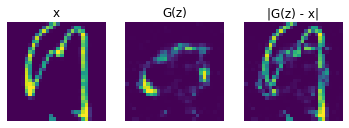

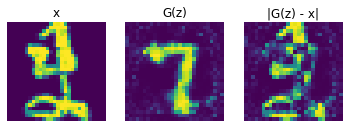

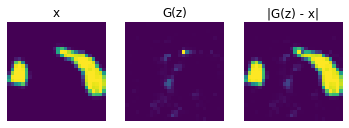

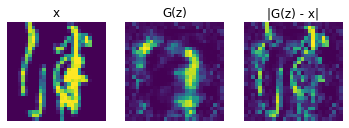

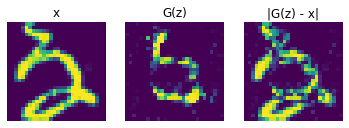

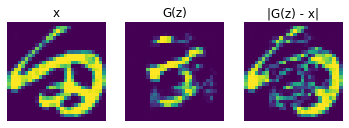

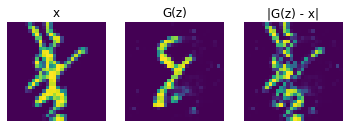

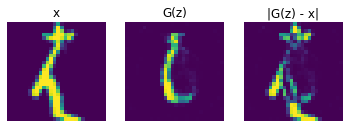

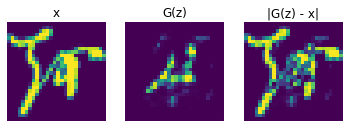

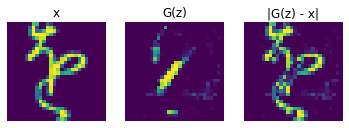

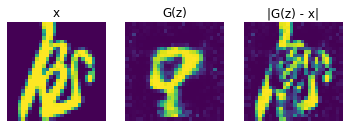

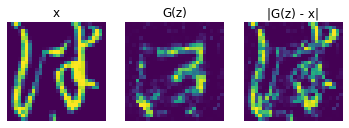

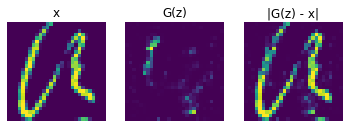

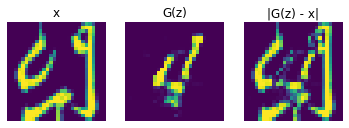

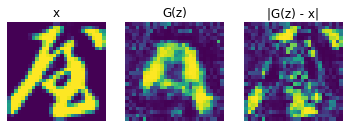

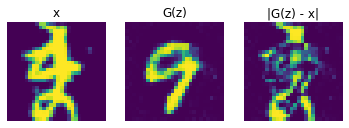

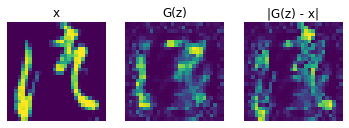

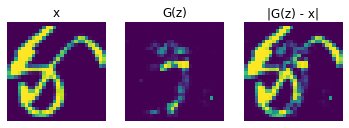

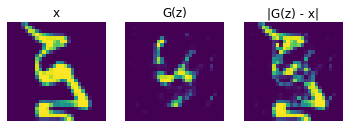

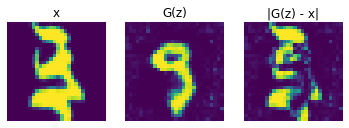

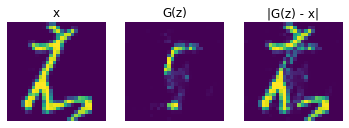

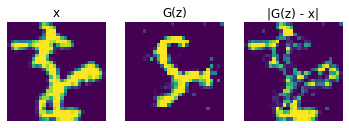

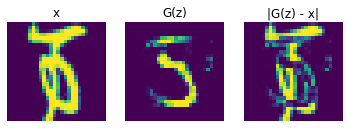

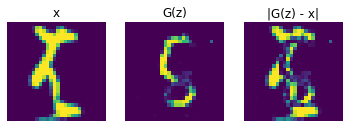

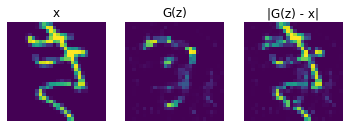

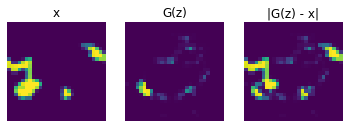

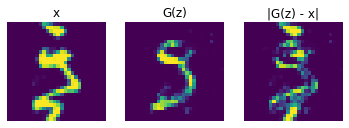

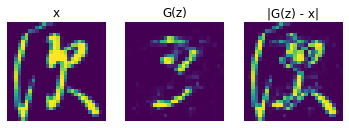

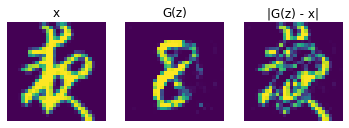

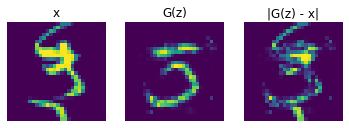

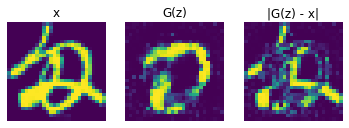

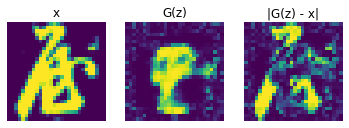

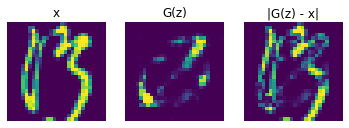

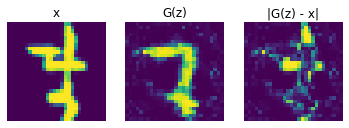

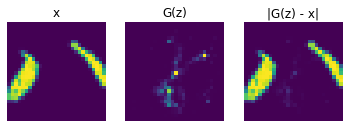

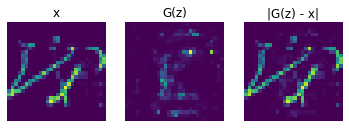

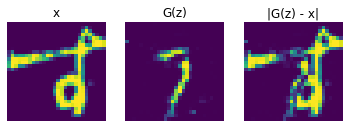

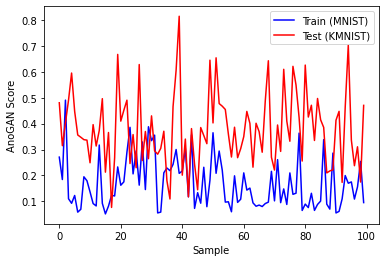

In [ ]:
def evaluate(dataset, N, noise, display = True):
    scores = []
    for i in tqdm(range(N)):
        x = dataset[i,0,...].reshape((1,-1)).to(device)
        x = x + noise * torch.randn(*x.shape).to(device)
        z,g, loss, residual_loss, discrimination_loss = anogan_z(x,G,D)
        scores.append(loss[-1])

        if display:
            plt.subplot(231)
            plt.title('x')
            plt.imshow(toimg(x))
            plt.axis('off')
            plt.subplot(232)
            plt.title('G(z)')
            plt.imshow(toimg(g))
            plt.axis('off')
            plt.subplot(233)
            plt.title('|G(z) - x|')
            plt.imshow(toimg(torch.abs(g - x)))
            plt.axis('off')
            # plt.savefig('kmnist_noise/' + str(i).zfill(2) + '.pdf')
            plt.show()
    return scores


noise = 0.0
display = True
scores_train = evaluate(batch_train,100, noise, display)
scores_test = evaluate(batch_test,100, noise, display)
plt.plot(scores_train,color = 'blue')
plt.plot(scores_test, color = 'red')
plt.legend(['Train (MNIST)','Test (KMNIST)'])
plt.xlabel('Sample')
plt.ylabel('AnoGAN Score')
plt.savefig('nonoise_scores.pdf')
plt.show()

In [ ]:
!zip -r kmnist_noise.zip kmnist_noise
!zip -r mnist_noise.zip mnist_noise

!zip -r kmnist_nonoise.zip kmnist_nonoise
!zip -r mnist_nonoise.zip mnist_nonoise

	zip warning: name not matched: kmnist_noise

zip error: Nothing to do! (try: zip -r kmnist_noise.zip . -i kmnist_noise)
	zip warning: name not matched: mnist_noise

zip error: Nothing to do! (try: zip -r mnist_noise.zip . -i mnist_noise)
	zip warning: name not matched: kmnist_nonoise

zip error: Nothing to do! (try: zip -r kmnist_nonoise.zip . -i kmnist_nonoise)
	zip warning: name not matched: mnist_nonoise

zip error: Nothing to do! (try: zip -r mnist_nonoise.zip . -i mnist_nonoise)
